In [1]:
import pybamm
pybamm.settings.heaviside_smoothing = 10
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.optimize import root

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)
#notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)
########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

# data set when at office 
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
# data set when at home


In [2]:
sat = 0.1
Sp_initial = 10e-4
kp = 1

In [3]:
cap = 0.211

Ms = 32
F = 9.649e4
V = 2.45
R = 8.3145
T = 298
ar = 0.960
I = cap*0.2#1.7
nu = 0.114

#f_l = np.sqrt(nu*Ms/2)# (Ms*nu/2)**(1/2)
#f_m = np.sqrt(nu*Ms)#(4*Ms*nu)**(1/2)
#f_h = np.sqrt(nu*Ms)*2/(8**(1/4))#(16*Ms*nu)**(1/4)

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

EL0 = 1.95
EM0 = 2.41
EH0 = 2.43

ih0 = 5
im0 = 5
il0 = 5


S8_initial = 0.0561

def S1_func(S2):
    constant = f_l*np.exp(F*(EL0-V)/(R*T))
    return constant*np.sqrt(S2)

def S2_func(S4, S8):
    return 0.336 - S4 - S8
#S2_initial = 0.4
def S4_root(S4):

    EH = EH0 + (R*T/F)*np.log( f_h*(S8_initial**(1/4)) / (S4**(1/2)) )
    eta_H = V - EH
    iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))

    S2 = S2_func(S4,S8_initial)

    EM = EM0 + (R*T/F)*np.log( f_m*(S4**(1/2)) / S2 ) 
    eta_M = V - EM
    iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))

    return I - iH - iM

In [4]:
print('S8 initial')
print(S8_initial)

# First find the root for S4
S4 = root(S4_root, 0.16)
S4_initial = S4['x'][0]
print('S4 initial')
print(S4_initial)

# Check root function is successful
print('Root')
print(S4_root(S4_initial))

# Third solve for S2 in terms of S4
#S2_initial = S2_func(S4_initial, S8_initial)
S2_initial = .336 - S8_initial-S4_initial
print('S2 initial')
print(S2_initial)

# check that V = EM0
print('EM0 initial')
print(EM0 + (R*T)*np.log(f_m*(S4_initial**(1/2))/S2_initial)/(F))

# current check
EH = EH0 + (R*T)*np.log(f_h*(S8_initial**(1/4))/(S4_initial**(1/2)))/(F)
eta_H = V - EH
iH = -2*ih0*ar*np.sinh(F*eta_H/(2*R*T))
print('iH initial')
print(iH)

EM = EM0 + (R*T/F)*np.log( f_m*(S4_initial**(1/2)) / S2_initial ) 
eta_M = V - EM
iM = -2*im0*ar*np.sinh(F*eta_M/(2*R*T))
print('iM initial')
print(iM)

print('iH+iM')
print(iH+iM)

# Fourth solve for S1 in terms of S2
S1_initial = S1_func(S2_initial)
print('S1 initial')
print(S1_initial)

# check that V = EL0
print('EL0 initial')
print(EL0 + (R*T)*np.log(f_l*(S2_initial**(1/2))/S1_initial)/(F))

S8 initial
0.0561
S4 initial
0.1335286095805121
Root
-7.388881173575612e-14
S2 initial
0.14637139041948793
EM0 initial
2.450109290367728
iH initial
0.021770706064780095
iM initial
0.020429293935293795
iH+iM
0.04220000000007389
S1 initial
1.806615680012001e-09
EL0 initial
2.45


In [5]:


model = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param = model.default_parameter_values
param.update(
    {
        "Current function [A]": .0422,
        "Initial Condition for Terminal Voltage [V]": 2.45,
        "Initial Condition for S8 ion [g]" : S8_initial,
        "Initial Condition for S4 ion [g]" : S4_initial,
        "Initial Condition for S2 ion [g]" : S2_initial,
        "Initial Condition for S ion [g]" : S1_initial,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial,
        "Lower voltage cut-off [V]" : 1.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": sat,
        'gamma': 10e40,
        'kappa': 10e12,
        'Shuttle rate coefficient during charge [s-1]': 0,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim = pybamm.Simulation(
    model,
    #experiment=experiment,
    parameter_values = param,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 6900#16950#3600*hours
sim.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

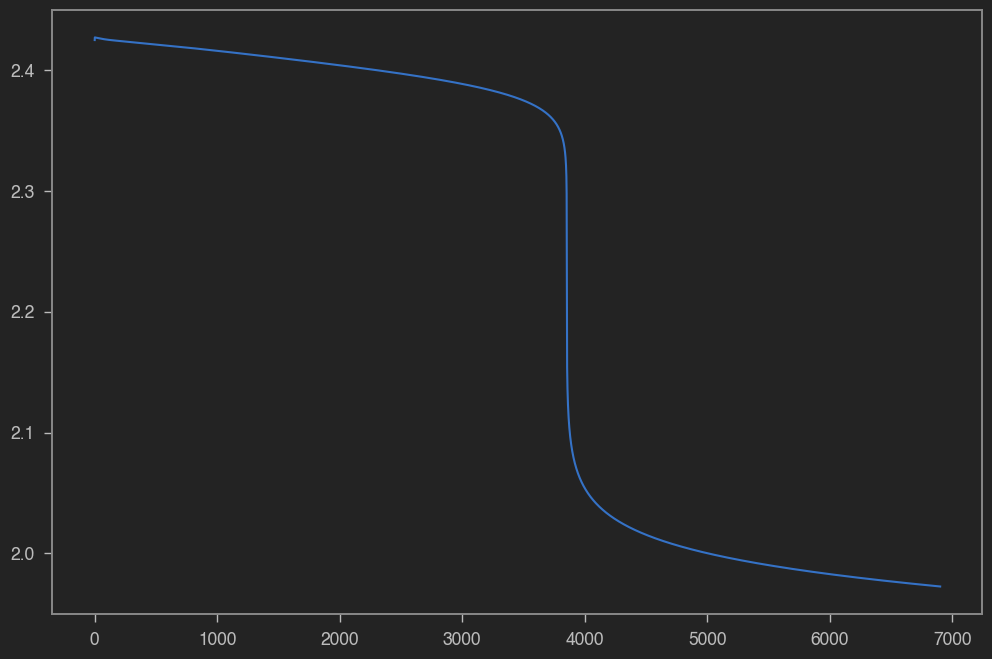

In [6]:
plt.plot(sim.solution.t,sim.solution["Terminal voltage [V]"].entries)

In [7]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 16500#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim) or time_check(sim) or voltage_check(sim):
            break_condition = False
        else:
            sim.step(1)
    except:
        condition = False






 Trying 100 







psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 15891.8 and h = 1.41693e-15, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 15891.8 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 15891.8 and h = 1.97574e-15, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 15891.8 and h = 2.01096e-15, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: ...

Low Voltage!





 Trying 50 










 Trying 10 










 Trying 1 







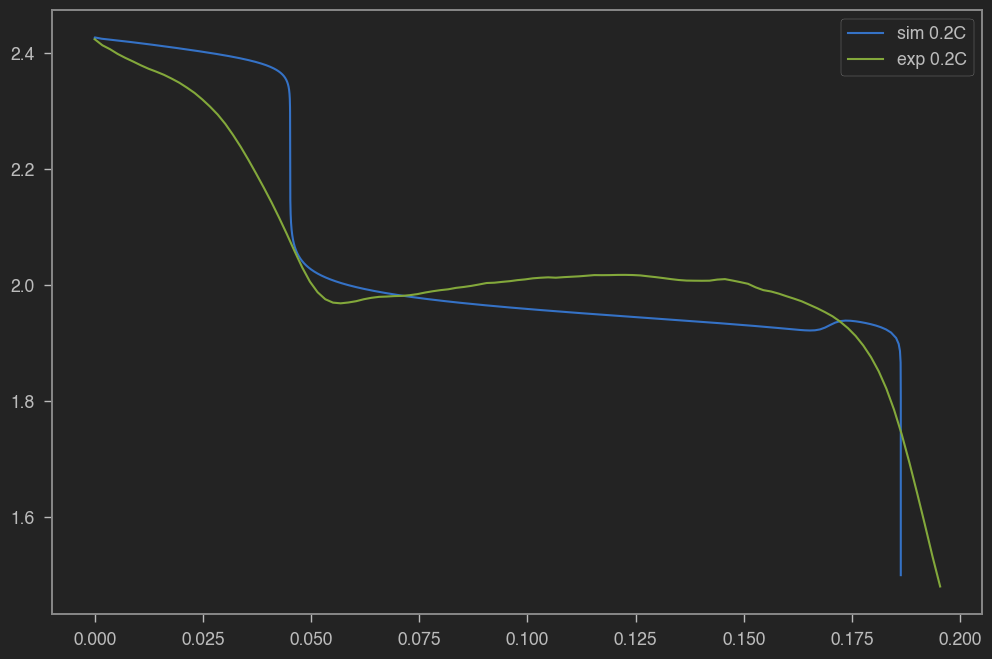

In [8]:
capacity = 0.0422*sim.solution.t/3600
V = sim.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.legend(["sim 0.2C","exp 0.2C" ])

In [9]:
# Initial conditions (DoD dependent)
loc = -1
S8_initial_cha = sim.solution['S8 [g]'].entries[loc]
S4_initial_cha = sim.solution['S4 [g]'].entries[loc]
S2_initial_cha = sim.solution['S2 [g]'].entries[loc]
S1_initial_cha = sim.solution['S [g]'].entries[loc]
Sp_initial_cha = sim.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_cha = sim.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_cha)
print(S4_initial_cha)
print(S2_initial_cha)
print(S1_initial_cha)
print(Sp_initial_cha)
print(V_initial_cha)

1.194913758912438e-12
9.495545388339674e-13
8.996334784696534e-12
0.10275811809178434
0.23424188370335924
1.500005654630088


In [10]:
model_cha = pybamm.lithium_sulfur.ZeroD_Chemistry_4()

param_cha = model_cha.default_parameter_values
param_cha.update(
    {
        "Current function [A]": -.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha,
        "Initial Condition for S4 ion [g]" : S4_initial_cha,
        "Initial Condition for S2 ion [g]" : S2_initial_cha,
        "Initial Condition for S ion [g]" : S1_initial_cha,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha,
        "Lower voltage cut-off [V]" : 1.2,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": sat,
        'gamma': 10e40,#10,
        'kappa': 10e12,
        'Shuttle rate coefficient during charge [s-1]': 0.0002,
        'Shuttle rate coefficient during discharge [s-1]': 0,
        'Precipitation rate [s-1]': kp
        
        }
)


sim_cha = pybamm.Simulation(
    model_cha,
    #experiment=experiment,
    parameter_values = param_cha,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-5,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)
hours = 4.8
time_in_seconds = 5#.67*7000#16950#3600*hours
sim_cha.solve(np.linspace(0, time_in_seconds, int(time_in_seconds)))

In [11]:
def negativity_check(sim):
    S8_end = sim.solution['S8 [g]'].entries[-1]
    S4_end = sim.solution['S4 [g]'].entries[-1]
    S2_end = sim.solution['S2 [g]'].entries[-1]
    S1_end = sim.solution['S [g]'].entries[-1]
    Sp_end = sim.solution['Precipitated Sulfur [g]'].entries[-1]
    if S8_end < 0 or S4_end < 0 or S2_end < 0 or S1_end < 0 or Sp_end < 0:
        print('Negative Species Values!')
        print(S8_end)
        print(S4_end)
        print(S2_end)
        print(S1_end)
        print(Sp_end)
        return True
    else:
        return False
    
def time_check(sim):
    time = 16500#24800#int(10 * cap*3600/I)# 3000#3240
    if sim.solution.t[-1] > time:
        return True
    else:
        return False

def voltage_check(sim):
    if sim.solution['Terminal voltage [V]'].entries[-1] < 1.55:
        print('Low Voltage!')
        return True
    elif sim.solution['Terminal voltage [V]'].entries[-1] > 2.49:
        print('High Voltage!')
        return True
    else:
        return False

condition = True 
break_condition = True
print('\n\n\n\n\n Trying 100 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(100)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 50 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(50)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 10 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(10)
    except:
        condition = False

condition = True 
print('\n\n\n\n\n Trying 1 \n\n\n\n\n')
while condition and break_condition:
    try:
        if negativity_check(sim_cha) or time_check(sim_cha) or voltage_check(sim_cha):
            break_condition = False
        else:
            sim_cha.step(1)
    except:
        condition = False






 Trying 100 










 Trying 50 










 Trying 10 










 Trying 1 







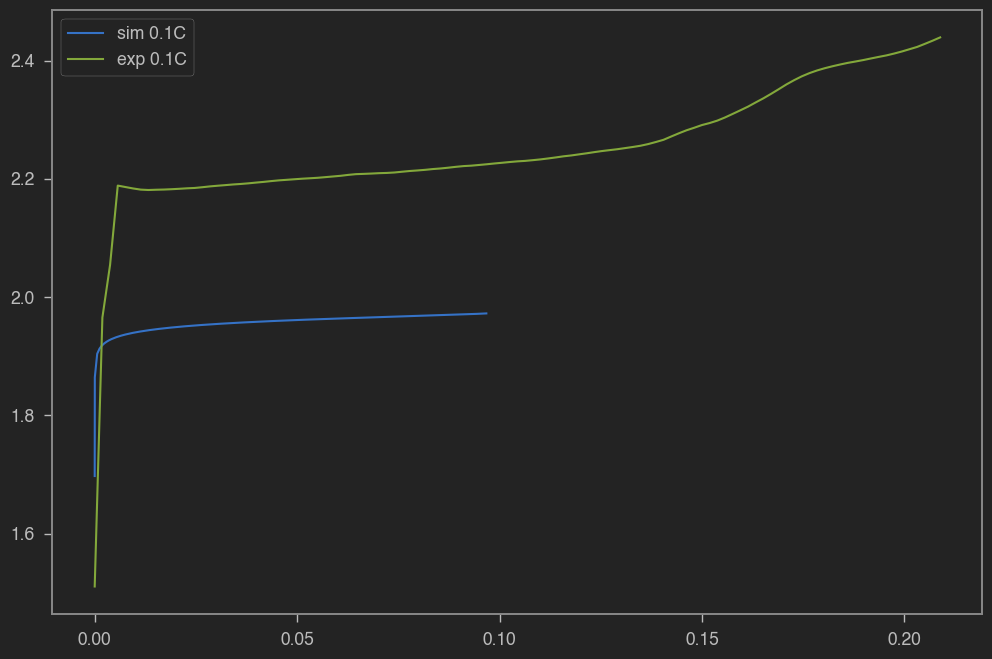

In [12]:
capacity = 0.0211*sim_cha.solution.t/3600
V = sim_cha.solution["Terminal voltage [V]"].entries
plt.plot(capacity, V)

# get experimental data
#filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
filename = '/Users/michaelcornish/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])

plt.legend(["sim 0.1C","exp 0.1C" ])